In [16]:
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)
from scipy.stats import mode

In [17]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')
df_hist_trans = pd.read_csv('../input/historical_transactions.csv')
df_new_merchant_trans = pd.read_csv('../input/new_merchant_transactions.csv')

In [18]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)


In [19]:
df_hist_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [20]:
merchants = pd.read_csv("../input/merchants.csv")

In [21]:
merchants.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [22]:
agg = {
    "numerical_1":['sum','max','min','mean','var'],
    "numerical_2":['sum','max','min','mean','var'],
    "category_1":{"mode" : lambda x : pd.Series.mode(x)[0]},
    "most_recent_sales_range":{"mode" : lambda x : pd.Series.mode(x)[0]},
    "most_recent_purchases_range":{"mode" : lambda x : pd.Series.mode(x)[0]},
    "avg_sales_lag3":['sum','max','min','mean','var'],
    "avg_purchases_lag3":['sum','max','min','mean','var'],
    "active_months_lag3":['sum','max','min','mean','var'],
    "avg_sales_lag6":['sum','max','min','mean','var'],
    "avg_purchases_lag6":['sum','max','min','mean','var'],
    "active_months_lag6":['sum','max','min','mean','var'],
    "avg_sales_lag12":['sum','max','min','mean','var'],    
    "avg_purchases_lag12":['sum','max','min','mean','var'],    
    "active_months_lag12":['sum','max','min','mean','var'],
    "category_4":{"mode" : lambda x : pd.Series.mode(x)},
    "category_2":{"mode" : lambda x : pd.Series.mode(x)},
    }

In [23]:
# merchant_aggregates = {}
# for col in ["merchant_group_id","merchant_category_id","subsector_id"] :
#     merchant_aggregates[col] = merchants.groupby(col).agg(agg)
#     merchant_aggregates[col].columns = ['_'.join(col).strip() for col in merchant_aggregates[col].columns.values]
# #     merchant_aggregates[col].reset_index(inplace=True)

In [24]:
len(df_hist_trans.columns.tolist())

14

In [25]:
from pandas import Series
merchant_to_merchant_group_id = Series(merchants.merchant_group_id.values,index=merchants.merchant_id).to_dict()

In [26]:
# df_hist_trans["merchant_group_id"] = df_hist_trans["merchant_id"].apply(lambda x:merchant_to_merchant_group_id[x])
# df_new_merchant_trans["merchant_group_id"] = df_new_merchant_trans["merchant_id"].apply(lambda x:merchant_to_merchant_group_id[x])

In [27]:
# from dask import dataframe as dd 
# from distributed import Client, LocalCluster
# cluster = LocalCluster()

# df_hist_trans_dd = dd.from_pandas(df_hist_trans, npartitions=100)

# df_new_merchant_trans_dd = dd.from_pandas(df_new_merchant_trans, npartitions=100)

# merchant_aggregates_dd = {}
# for col in ["merchant_group_id","merchant_category_id","subsector_id"]:
#     merchant_aggregates_dd[col] = dd.from_pandas(merchant_aggregates[col], npartitions=100)

In [ ]:
# df_hist_trans.to_csv("df_hist_trans.csv")
# .to_csv("df_hist_trans.csv")

In [15]:
# import gc
# for col in ["merchant_group_id","merchant_category_id","subsector_id"]:
#     print("doing join for " , col)
#     df_hist_trans_dd = df_hist_trans_dd.set_index(col)
#     df_hist_trans_dd = df_hist_trans_dd.merge(merchant_aggregates_dd[col],on=col,how='left')
    
#     df_hist_trans_dd = df_hist_trans_dd.reset_index()

# df_hist_trans_dd.compute()
    
# df_hist_trans_dd.to_csv("/df_hist_trans/df_hist_trans.csv")

# del df_hist_trans
# gc.collect()

doing join for  merchant_group_id
doing join for  merchant_category_id
doing join for  subsector_id


tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x1a2b224f98>>
Traceback (most recent call last):
  File "/Users/raghavan/anaconda2/envs/py36/lib/python3.6/site-packages/tornado/ioloop.py", line 1229, in _run
    return self.callback()
  File "/Users/raghavan/anaconda2/envs/py36/lib/python3.6/site-packages/bokeh/server/tornado.py", line 514, in _keep_alive
    c.send_ping()
  File "/Users/raghavan/anaconda2/envs/py36/lib/python3.6/site-packages/bokeh/server/connection.py", line 46, in send_ping
    self._socket.ping(codecs.encode(str(self._ping_count), "utf-8"))
  File "/Users/raghavan/anaconda2/envs/py36/lib/python3.6/site-packages/tornado/websocket.py", line 367, in ping
    self.ws_connection.write_ping(data)
  File "/Users/raghavan/anaconda2/envs/py36/lib/python3.6/site-packages/tornado/websocket.py", line 882, in write_ping
    self._write_frame(True, 0x9, data)
  File "/Users/raghavan/anaco

OSError: [Errno 22] Invalid argument

In [ ]:
# for col in ["merchant_group_id","merchant_category_id","subsector_id"]:
#     print("doing join for " , col)
#     df_new_merchant_trans.set_index(col,inplace=True)
#     df_new_merchant_trans = df_new_merchant_trans.merge(merchant_aggregates[col],on=col,how='left')
    
#     df_new_merchant_trans.reset_index(inplace=True)
    
# df_new_merchant_trans.to_csv("df_new_merchant_trans.csv")

# del df_new_merchant_trans
# gc.collect()

In [ ]:
# df_hist_trans.to_csv("df_hist_trans.csv")

In [ ]:
# df_new_merchant_trans.to_csv("df_new_merchant_trans.csv")

In [82]:
holidays = np.asarray([np.datetime64(date) for date in ['2017-01-01','2017-02-27','2017-02-28','2017-03-01','2017-04-14','2017-04-16','2017-04-21','2017-05-01','2017-06-15','2017-09-07','2017-10-12','2017-11-02','2017-11-15','2017-12-25','2018-01-01','2018-02-12','2018-02-13','2018-03-30','2018-04-21','2018-05-01','2018-05-31','2018-09-07','2018-10-12','2018-11-02','2018-11-15','2018-11-20','2018-12-25']])
seasons = [0,0,0,1,1,1,2,2,2,4,4,4]

def closest_holiday_days(x):
    deltas = holidays - np.datetime64(x)
    vect_abs = np.vectorize(abs)
    vect_days = np.vectorize(lambda x: x)
    absed = vect_abs(vect_days(deltas))
    return min(absed).item().days

In [83]:
%timeit closest_holiday_days(datetime.datetime.today())

238 µs ± 5.13 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [84]:
import dask.dataframe as dd

# df_hist_trans = df_hist_trans.head(10000)
# df_new_merchant_trans = df_new_merchant_trans.head(10000)

tqdm.pandas()


for df in [df_hist_trans,df_new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])    
    print("processsed purchase_date")
    df['year'] = df['purchase_date'].dt.year
    print("year") 
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    print("wof")     
    df['month'] = df['purchase_date'].dt.month
    print("month")         
    df['season'] = df['month'].apply(lambda x:seasons[x-1])
    print("season")    
    df['closest_date_to_holiday'] = df['purchase_date'].progress_apply(closest_holiday_days)
    print("holiday")             
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    print("dayofweek")    
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    print("weekend")        
    df['hour'] = df['purchase_date'].dt.hour
    print("hour")    
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    print("AF")            
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    print("cat_1")    
    #https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    print("month_diff")                
    df['month_diff'] += df['month_lag']

processsed purchase_date
year
wof
month


  0%|          | 0/29112361 [00:00<?, ?it/s]

season


100%|██████████| 29112361/29112361 [1:56:05<00:00, 4179.24it/s]  


holiday
dayofweek
weekend
hour
AF
cat_1
month_diff
processsed purchase_date
year
wof
month


  0%|          | 0/1963031 [00:00<?, ?it/s]

season


100%|██████████| 1963031/1963031 [07:43<00:00, 4232.91it/s]


holiday
dayofweek
weekend
hour
AF
cat_1
month_diff


In [85]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [86]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['season'] = ['sum','max','min','mean','var']
aggs['closest_date_to_holiday'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_hist_trans[col+'_mean'] = df_hist_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']    

new_columns = get_new_columns('hist',aggs)
df_hist_trans_group = df_hist_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['hist_purchase_date_diff'] = (df_hist_trans_group['hist_purchase_date_max'] - df_hist_trans_group['hist_purchase_date_min']).dt.days
df_hist_trans_group['hist_purchase_date_average'] = df_hist_trans_group['hist_purchase_date_diff']/df_hist_trans_group['hist_card_id_size']
df_hist_trans_group['hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

112

In [87]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']
    
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['season'] = ['sum','max','min','mean','var']
aggs['closest_date_to_holiday'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_new_merchant_trans[col+'_mean'] = df_new_merchant_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']
    
new_columns = get_new_columns('new_hist',aggs)
df_hist_trans_group = df_new_merchant_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['new_hist_purchase_date_diff'] = (df_hist_trans_group['new_hist_purchase_date_max'] - df_hist_trans_group['new_hist_purchase_date_min']).dt.days
df_hist_trans_group['new_hist_purchase_date_average'] = df_hist_trans_group['new_hist_purchase_date_diff']/df_hist_trans_group['new_hist_card_id_size']
df_hist_trans_group['new_hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['new_hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

42

In [88]:
del df_hist_trans;gc.collect()
del df_new_merchant_trans;gc.collect()
df_train.head(5)


,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,...,new_hist_weekend_sum,new_hist_weekend_mean,new_hist_category_1_sum,new_hist_category_1_mean,new_hist_card_id_size,new_hist_category_2_mean_mean,new_hist_category_3_mean_mean,new_hist_purchase_date_diff,new_hist_purchase_date_average,new_hist_purchase_date_uptonow
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,9,23,35,7,...,6.0,0.260870,0.0,0.000000,23.0,-0.550160,-0.592993,54.0,2.347826,228.0
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,12,24,50,7,...,0.0,0.000000,0.0,0.000000,6.0,-0.550160,-0.606486,56.0,9.333333,258.0
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,10,14,22,7,...,1.0,1.000000,0.0,0.000000,1.0,-0.549015,-0.592993,0.0,0.000000,229.0
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,6,16,20,7,...,3.0,0.428571,1.0,0.142857,7.0,-0.556518,-0.604559,41.0,5.857143,239.0
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,4,22,17,7,...,12.0,0.333333,2.0,0.055556,36.0,-0.555446,-0.588217,57.0,1.583333,229.0


In [89]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [90]:
for df in [df_train,df_test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']

for f in ['feature_1','feature_2','feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)


In [91]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = df_train['target']
del df_train['target']

In [92]:
df_train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,hist_year_nunique,...,new_hist_purchase_date_uptonow,outliers,dayofweek,weekofyear,month,elapsed_time,hist_first_buy,new_hist_first_buy,card_id_total,purchase_amount_total
0,2017-06-01,C_ID_92a2005557,0.013145,0.008752,0.011428,9,23,35,7,2,...,228.0,0,3,22,6,561,26,277.0,283.0,-179.212942
1,2017-01-01,C_ID_3d0044924f,0.010712,0.011385,0.010283,12,24,50,7,2,...,258.0,0,6,52,1,712,5,396.0,356.0,-214.362071
2,2016-08-01,C_ID_d639edf6cd,0.010610,0.008752,0.010283,10,14,22,7,2,...,229.0,0,0,31,8,865,163,635.0,44.0,-29.867717
3,2017-09-01,C_ID_186d6a6901,0.010712,0.014166,0.010283,6,16,20,7,2,...,239.0,0,4,35,9,469,25,187.0,84.0,-54.145736
4,2017-11-01,C_ID_cdbd2c0db2,0.008058,0.014166,0.010283,4,22,17,7,2,...,229.0,0,2,44,11,408,11,121.0,169.0,-68.613893


In [93]:
df_train.isna().sum()

first_active_month                           0
card_id                                      0
feature_1                                    0
feature_2                                    0
feature_3                                    0
hist_month_nunique                           0
hist_hour_nunique                            0
hist_weekofyear_nunique                      0
hist_dayofweek_nunique                       0
hist_year_nunique                            0
hist_subsector_id_nunique                    0
hist_merchant_id_nunique                     0
hist_merchant_category_id_nunique            0
hist_purchase_amount_sum                     0
hist_purchase_amount_max                     0
hist_purchase_amount_min                     0
hist_purchase_amount_mean                    0
hist_purchase_amount_var                     0
hist_installments_sum                        0
hist_installments_max                        0
hist_installments_min                        0
hist_installm

In [94]:
df_train.to_csv("elo_train.csv")

In [95]:
df_test.to_csv("elo_test.csv")

In [138]:
df_train = pd.read_csv("elo_train.csv")
df_test = pd.read_csv("elo_test.csv")

In [139]:
x = df_train.columns.to_series().groupby(df.dtypes).groups
x

{dtype('<M8[ns]'): Index(['first_active_month'], dtype='object'),
 dtype('int64'): Index(['hist_month_nunique', 'hist_hour_nunique', 'hist_weekofyear_nunique',
        'hist_dayofweek_nunique', 'hist_year_nunique',
        'hist_subsector_id_nunique', 'hist_merchant_id_nunique',
        'hist_merchant_category_id_nunique', 'hist_installments_sum',
        'hist_installments_max', 'hist_installments_min', 'hist_season_sum',
        'hist_season_max', 'hist_season_min',
        'hist_closest_date_to_holiday_sum', 'hist_closest_date_to_holiday_max',
        'hist_closest_date_to_holiday_min', 'hist_month_lag_max',
        'hist_month_lag_min', 'hist_authorized_flag_sum', 'hist_weekend_sum',
        'hist_category_1_sum', 'hist_card_id_size', 'hist_purchase_date_diff',
        'hist_purchase_date_uptonow'],
       dtype='object'),
 dtype('float64'): Index(['feature_1', 'feature_2', 'feature_3', 'hist_purchase_amount_sum',
        'hist_purchase_amount_max', 'hist_purchase_amount_min',
    

In [140]:
col_seris = df_train.isna().sum() == 0
col_df = pd.DataFrame({'email':col_seris.index, 'has_na':col_seris.values})
na_columns_train = col_df[col_df["has_na"] == False].email.tolist()

col_seris = df_test.isna().sum() == 0
col_df = pd.DataFrame({'email':col_seris.index, 'has_na':col_seris.values})
na_columns_test = col_df[col_df["has_na"] == False].email.tolist()

In [141]:
na_columns = set(na_columns_train).union(set(na_columns_test))

In [142]:
print(na_columns)
print(len(na_columns))

{'new_hist_category_3_mean_mean', 'month', 'card_id_total', 'new_hist_category_1_mean', 'first_active_month', 'new_hist_month_lag_min', 'new_hist_year_nunique', 'new_hist_merchant_id_nunique', 'new_hist_month_diff_mean', 'new_hist_purchase_amount_var', 'new_hist_month_lag_max', 'new_hist_season_min', 'weekofyear', 'new_hist_card_id_size', 'new_hist_purchase_amount_max', 'new_hist_purchase_amount_min', 'new_hist_closest_date_to_holiday_sum', 'new_hist_first_buy', 'dayofweek', 'new_hist_closest_date_to_holiday_min', 'new_hist_season_var', 'new_hist_category_1_sum', 'new_hist_weekend_sum', 'new_hist_purchase_date_average', 'new_hist_closest_date_to_holiday_max', 'new_hist_installments_sum', 'new_hist_month_nunique', 'new_hist_category_2_mean_mean', 'new_hist_weekend_mean', 'new_hist_installments_mean', 'new_hist_month_lag_var', 'new_hist_purchase_amount_mean', 'new_hist_subsector_id_nunique', 'new_hist_closest_date_to_holiday_var', 'new_hist_installments_var', 'new_hist_month_lag_mean', '

In [146]:
# from sklearn.preprocessing import PolynomialFeatures
# # df_train["card_id"] = df_train_string["card_id"]
# df_train_string = df_train[["card_id","first_active_month"]]

# del df_train["card_id"]
# del df_train["first_active_month"]

# df_train_new = PolynomialFeatures(degree=2).fit(df_train)
# # df_test = PolynomialFeatures(degree=2).fit(df_test)

In [143]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.66532	valid_1's rmse: 3.72098
[200]	training's rmse: 3.58544	valid_1's rmse: 3.6866
[300]	training's rmse: 3.53792	valid_1's rmse: 3.67279
[400]	training's rmse: 3.50118	valid_1's rmse: 3.66493
[500]	training's rmse: 3.47082	valid_1's rmse: 3.65983
[600]	training's rmse: 3.44513	valid_1's rmse: 3.65646
[700]	training's rmse: 3.42105	valid_1's rmse: 3.65395
[800]	training's rmse: 3.39986	valid_1's rmse: 3.65264
[900]	training's rmse: 3.38042	valid_1's rmse: 3.65147
[1000]	training's rmse: 3.36279	valid_1's rmse: 3.65058
[1100]	training's rmse: 3.34654	valid_1's rmse: 3.64982
[1200]	training's rmse: 3.33091	valid_1's rmse: 3.64901
Early stopping, best iteration is:
[1194]	training's rmse: 3.3317	valid_1's rmse: 3.64901
fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.66611	valid_1's rmse: 3.71722
[200]	training's rmse: 3.58691	valid_1's rmse: 3.6865

3.653476817542801

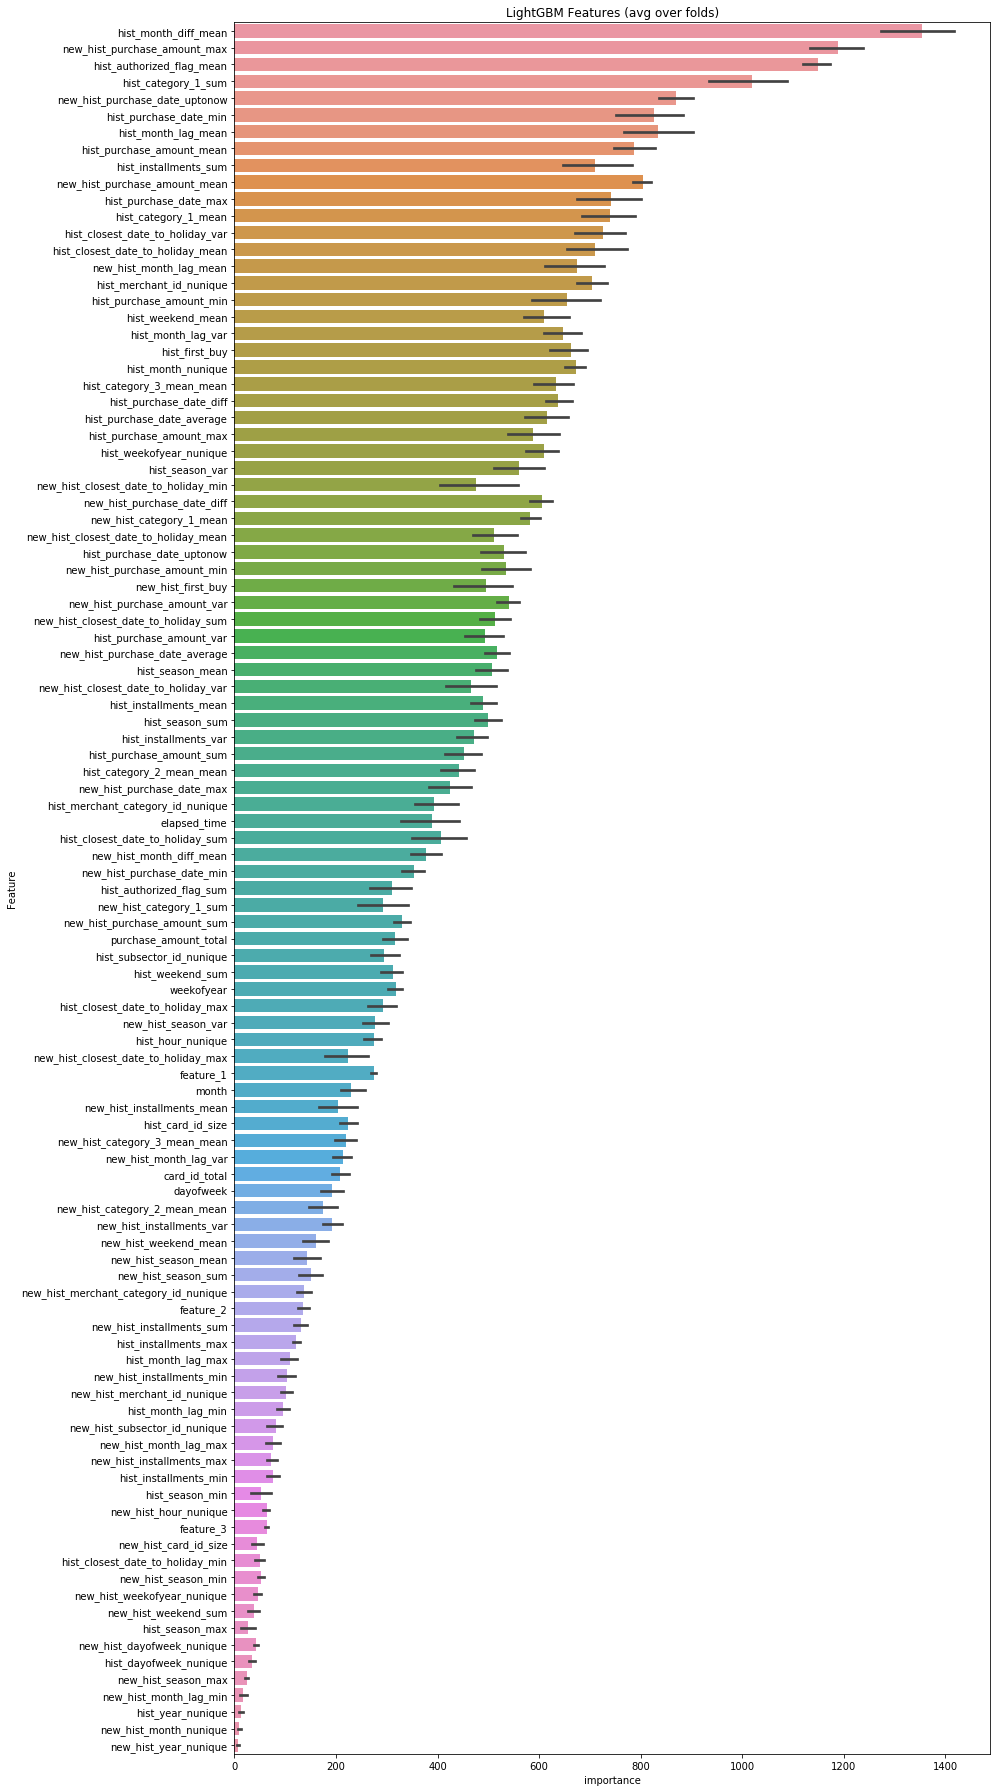

In [144]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')


In [145]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission_refactored.csv", index=False)

In [155]:
pd.set_option('display.max_columns', None)

In [178]:
from scipy import stats

In [231]:
df_train.columns.tolist()

['Unnamed: 0',
 'first_active_month',
 'card_id',
 'feature_1',
 'feature_2',
 'feature_3',
 'hist_month_nunique',
 'hist_hour_nunique',
 'hist_weekofyear_nunique',
 'hist_dayofweek_nunique',
 'hist_year_nunique',
 'hist_subsector_id_nunique',
 'hist_merchant_id_nunique',
 'hist_merchant_category_id_nunique',
 'hist_purchase_amount_sum',
 'hist_purchase_amount_max',
 'hist_purchase_amount_min',
 'hist_purchase_amount_mean',
 'hist_purchase_amount_var',
 'hist_installments_sum',
 'hist_installments_max',
 'hist_installments_min',
 'hist_installments_mean',
 'hist_installments_var',
 'hist_season_sum',
 'hist_season_max',
 'hist_season_min',
 'hist_season_mean',
 'hist_season_var',
 'hist_closest_date_to_holiday_sum',
 'hist_closest_date_to_holiday_max',
 'hist_closest_date_to_holiday_min',
 'hist_closest_date_to_holiday_mean',
 'hist_closest_date_to_holiday_var',
 'hist_purchase_date_max',
 'hist_purchase_date_min',
 'hist_month_lag_max',
 'hist_month_lag_min',
 'hist_month_lag_mean',
 

In [226]:
len(a)

60

In [171]:
mode([1,3,2,3,5])[0][0]

3

In [ ]:
# holidays = [1,3,2,3,5]
print(holidays)
a = [date for date in holidays]

In [ ]:
min(df_new_merchant_trans["purchase_date"])

In [ ]:
max(df_new_merchant_trans["purchase_date"])

In [ ]:
df_new_merchant_trans.dtypes

In [ ]:
[pd.to_datetime(date) for date in ["Jan 01, 2017","Feb 27, 2017","Feb 28, 2017","Mar 01, 2017","Apr 14, 2017","Apr 16, 2017","Apr 21, 2017","May 01, 2017","Jun 15, 2017","Sep 07, 2017","Oct 12, 2017","Nov 02, 2017","Nov 15, 2017","Dec 25, 2017","1 Jan 2018","12 Feb 2018","13 Feb 2018","30 Mar 2018","21 Apr 2018","1 May 2018","31 May 2018","7 Sep 2018","12 Oct 2018","2 Nov 2018","15 Nov 2018","20 Nov 2018","25 Dec 2018"]]

In [ ]:
(pd.to_datetime("Apr 21, 2017") - pd.to_datetime('2017-01-01 00:00:08')).days

In [29]:
holidays = np.asarray([pd.to_datetime(date) for date in ["Jan 01, 2017","Feb 27, 2017","Feb 28, 2017","Mar 01, 2017","Apr 14, 2017","Apr 16, 2017","Apr 21, 2017","May 01, 2017","Jun 15, 2017","Sep 07, 2017","Oct 12, 2017","Nov 02, 2017","Nov 15, 2017","Dec 25, 2017","1 Jan 2018","12 Feb 2018","13 Feb 2018","30 Mar 2018","21 Apr 2018","1 May 2018","31 May 2018","7 Sep 2018","12 Oct 2018","2 Nov 2018","15 Nov 2018","20 Nov 2018","25 Dec 2018"]])

In [34]:
[i.strftime("%Y-%m-%d") for i in holidays]

['2017-01-01',
 '2017-02-27',
 '2017-02-28',
 '2017-03-01',
 '2017-04-14',
 '2017-04-16',
 '2017-04-21',
 '2017-05-01',
 '2017-06-15',
 '2017-09-07',
 '2017-10-12',
 '2017-11-02',
 '2017-11-15',
 '2017-12-25',
 '2018-01-01',
 '2018-02-12',
 '2018-02-13',
 '2018-03-30',
 '2018-04-21',
 '2018-05-01',
 '2018-05-31',
 '2018-09-07',
 '2018-10-12',
 '2018-11-02',
 '2018-11-15',
 '2018-11-20',
 '2018-12-25']